In [1]:
import os
import sys
import math
import json
import torch
import numpy as np

import scipy.io
from scipy import ndimage
import matplotlib
# from skimage import io
# matplotlib.use("pgf")
matplotlib.rcParams.update({
    # 'font.family': 'serif',
    'font.size':10,
})
from matplotlib import pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
seed_everything(42)

import DiffNet
from DiffNet.DiffNetFEM import DiffNet2DFEM
from torch.utils import data
# from e1_stokes_base_resmin import Stokes2D

from pytorch_lightning.callbacks.base import Callback
from e2_ns_fps_resmin import OptimSwitchLBFGS, NS_FPS_Dataset, NS_FPS

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
Global seed set to 42
Global seed set to 42


In [12]:
def plot_contours(module, u, v, p, u_x_gp, v_y_gp, path=None):
    self = module
    fig, axs = plt.subplots(3, 3, figsize=(6*3,3*3),
                        subplot_kw={'aspect': 'auto'}, squeeze=True)
    
    for i in range(axs.shape[0]-1):
        for j in range(axs.shape[1]):
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

    div_gp = u_x_gp + v_y_gp
    div_elmwise = torch.sum(div_gp, 0)
    div_total = torch.sum(div_elmwise)
    
    interp_method = 'bilinear'
    im0 = axs[0,0].imshow(u,cmap='jet', origin='lower', interpolation=interp_method)
    fig.colorbar(im0, ax=axs[0,0]); axs[0,0].set_title(r'$u_x$')
    im1 = axs[0,1].imshow(v,cmap='jet',origin='lower', interpolation=interp_method)
    fig.colorbar(im1, ax=axs[0,1]); axs[0,1].set_title(r'$u_y$')
    im2 = axs[0,2].imshow(p,cmap='jet',origin='lower', interpolation=interp_method)
    fig.colorbar(im2, ax=axs[0,2]); axs[0,2].set_title(r'$p$')

    im3 = axs[1,0].imshow(div_elmwise,cmap='jet',origin='lower', interpolation=interp_method)
    fig.colorbar(im3, ax=axs[1,0]); axs[1,0].set_title(r'$\int(\nabla\cdot u) d\Omega = $' + '{:.3e}'.format(div_total.item()))
    im4 = axs[1,1].imshow((u**2 + v**2)**0.5,cmap='jet',origin='lower', interpolation=interp_method)
    fig.colorbar(im4, ax=axs[1,1]); axs[1,1].set_title(r'$\sqrt{u_x^2+u_y^2}$')
    x = np.linspace(0, 1, u.shape[1])
    y = np.linspace(0, 1, u.shape[0])
    xx , yy = np.meshgrid(x, y)
    print(x.shape)
    print(y.shape)
    print(xx.shape)
    print(yy.shape)
    print(u.shape)
    print(v.shape)
    im5 = axs[1,2].streamplot(xx, yy, u, v, color='k', cmap='jet'); axs[1,2].set_title("Streamlines")

    mid_idxX = int(self.domain_sizeX/2)
    mid_idxY = int(self.domain_sizeY/2)
#     im = axs[2,0].plot(self.dataset.y[:,0], u[:,0],label='u_inlet')
    im = axs[2,0].plot(self.dataset.x[mid_idxY,:], u[mid_idxY,:],label='u_mid')
    im = axs[2,1].plot(self.dataset.x[mid_idxY,:], v[mid_idxY,:],label='v_mid')
    im = axs[2,2].plot(self.dataset.x[mid_idxY,:], p[mid_idxY,:],label='p_mid')
    
    if not path == None:
        plt.savefig(path)
#     im = axs[2,0].plot(self.dataset.y[:,mid_idx], u[:,mid_idx],label='DiffNet')
#     im = axs[2,0].plot(self.midline_Y,self.midline_U,label='Numerical')
#     axs[2,0].set_xlabel('y'); axs[2,0].legend(); axs[2,0].set_title(r'$u_x @ x=0.5$')
#     im = axs[2,1].plot(self.dataset.x[mid_idx,:], v[mid_idx,:],label='DiffNet')
#     im = axs[2,1].plot(self.midline_X,self.midline_V,label='Numerical')
#     axs[2,1].set_xlabel('x'); axs[2,1].legend(); axs[2,1].set_title(r'$u_y @ y=0.5$')
#     im = axs[2,2].plot(self.dataset.x[-1,:], p[-1,:],label='DiffNet')
#     im = axs[2,2].plot(self.midline_X,self.topline_P,label='Numerical')
#     axs[2,2].set_xlabel('x'); axs[2,2].legend(); axs[2,2].set_title(r'$p @ y=1.0$')

#     fig.suptitle("Re = {:.1f}, N = {}, LR = {:.1e}".format(self.Re, self.domain_size, self.learning_rate), fontsize=12)

#     plt.savefig(os.path.join(self.logger[0].log_dir, 'contour_' + str(self.current_epoch) + '.png'))
#     self.logger[0].experiment.add_figure('Contour Plots', fig, self.current_epoch)
#     plt.close('all')

In [3]:
lx = 12.
ly = 6.
Nx = 128
Ny = 64
domain_size = 32
Re = 1.
dir_string = "ns_fps"
max_epochs = 50001
plot_frequency = 100
LR = 5e-3
opt_switch_epochs = max_epochs
load_from_prev = False
load_version_id = 25

x = np.linspace(0, lx, Nx)
y = np.linspace(0, ly, Ny)
xx , yy = np.meshgrid(x, y)

In [4]:
dataset = NS_FPS_Dataset(domain_lengths=(lx,ly), domain_sizes=(Nx,Ny), Re=Re)

if load_from_prev:
    print("LOADING FROM PREVIOUS VERSION: ", load_version_id)
    case_dir = './ns_fps/version_'+str(load_version_id)
    net_u = torch.load(os.path.join(case_dir, 'net_u.pt'))
    net_v = torch.load(os.path.join(case_dir, 'net_v.pt'))
    net_p = torch.load(os.path.join(case_dir, 'net_p.pt'))        
else:
    print("INITIALIZING PARAMETERS TO ZERO")
    v1 = np.zeros_like(dataset.x)
    v2 = np.zeros_like(dataset.x)
    p  = np.zeros_like(dataset.x)
    u_tensor = np.expand_dims(np.array([v1,v2,p]),0)

    # network = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor), requires_grad=True)])
    net_u = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor[:,0:1,:,:]), requires_grad=True)])
    net_v = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor[:,1:2,:,:]), requires_grad=True)])
    net_p = torch.nn.ParameterList([torch.nn.Parameter(torch.FloatTensor(u_tensor[:,2:3,:,:]), requires_grad=True)])
# print("net_u = \n", net_u[0])
# print("net_v = \n", net_v[0])
# print("net_p = \n", net_p[0])
network = (net_u, net_v, net_p)
basecase = NS_FPS(network, dataset, domain_lengths=(lx,ly), domain_sizes=(Nx,Ny), batch_size=1, fem_basis_deg=1, learning_rate=LR, plot_frequency=plot_frequency)

# Initialize trainer
logger = pl.loggers.TensorBoardLogger('.', name=dir_string)
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

early_stopping = pl.callbacks.early_stopping.EarlyStopping('loss',
    min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

lbfgs_switch = OptimSwitchLBFGS(epochs=opt_switch_epochs)

trainer = Trainer(gpus=[0],callbacks=[early_stopping,lbfgs_switch],
    checkpoint_callback=checkpoint, logger=[logger,csv_logger],
    max_epochs=max_epochs, deterministic=True, profiler="simple")

# Training
trainer.fit(basecase)
# Save network
torch.save(basecase.net_u, os.path.join(logger.log_dir, 'net_u.pt'))
torch.save(basecase.net_v, os.path.join(logger.log_dir, 'net_v.pt'))
torch.save(basecase.net_p, os.path.join(logger.log_dir, 'net_p.pt'))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


INITIALIZING PARAMETERS TO ZERO
N_gp =  ParameterList(
    (0): Parameter containing: [torch.FloatTensor of size 1x1x2x2]
    (1): Parameter containing: [torch.FloatTensor of size 1x1x2x2]
    (2): Parameter containing: [torch.FloatTensor of size 1x1x2x2]
    (3): Parameter containing: [torch.FloatTensor of size 1x1x2x2]
)
N_gp_surf =  ParameterList(
    (0): Parameter containing: [torch.FloatTensor of size 1x1x2]
    (1): Parameter containing: [torch.FloatTensor of size 1x1x2]
)
N_gp[0] = 
 Parameter containing:
tensor([[[[0.6220084429, 0.1666666716],
          [0.1666666716, 0.0446581990]]]])
N_gp[1] = 
 Parameter containing:
tensor([[[[0.1666666716, 0.6220084429],
          [0.0446581990, 0.1666666716]]]])
N_gp[2] = 
 Parameter containing:
tensor([[[[0.1666666716, 0.0446581990],
          [0.6220084429, 0.1666666716]]]])
N_gp[3] = 
 Parameter containing:
tensor([[[[0.0446581990, 0.1666666716],
          [0.1666666716, 0.6220084429]]]])
N_gp_surf[0] = 
 Parameter containing:
tensor([

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory ./ns_fps/version_61 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

   | Name         | Type          | Params
------------------------------------------------
0  | network      | ParameterList | 8.2 K 
1  | N_gp         | ParameterList | 16    
2  | dN_x_gp      | ParameterList | 16    
3  | dN_y_gp      | ParameterList | 16    
4  | d2N_x_gp     | ParameterList | 16    
5  | d2N_y_gp     | ParameterList | 16    
6  | d2N_xy_gp    | ParameterList | 16    
7  | N_gp_surf    | ParameterList | 4     
8  | dN_x_gp_surf | ParameterList | 4     
9  | dN_y_gp_surf | ParameterList | 4     
10 | net_v        | ParameterList | 8.2 K 
11 | net_p        | ParameterList | 8.2 K 
------------------------------------------------
24.6 K    Trainab

Epoch 0:   8%|▊         | 8/100 [00:00<00:01, 47.85it/s, loss=9.11, v_num=1_61]

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 1:  46%|████▌     | 46/100 [00:00<00:01, 50.72it/s, loss=3.24, v_num=1_61] 

/work/baskarg/bkhara/python_virtual_envs/lightning/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


(128,)
(64,)
(64, 128)
(64, 128)
torch.Size([64, 128])
torch.Size([64, 128])


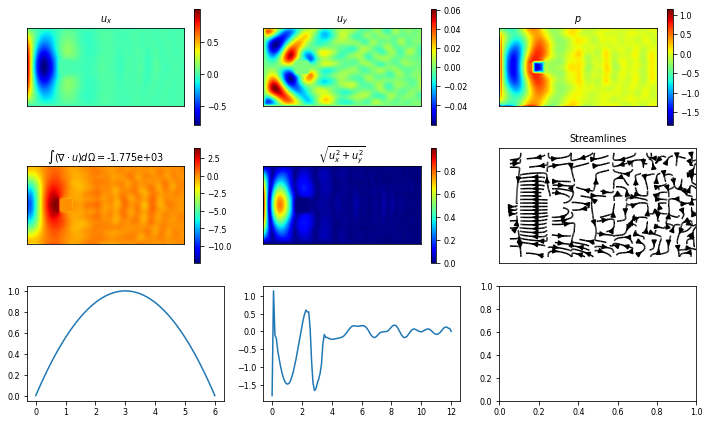

In [24]:
# Query
basecase.dataset[0]
inputs, forcing = basecase.dataset[0]
u, v, p, u_x, v_y = basecase.do_query(inputs, forcing)
u =   u.squeeze().detach().cpu()
v =   v.squeeze().detach().cpu()
p =   p.squeeze().detach().cpu()
u_x = u_x.squeeze().detach().cpu()
v_y = v_y.squeeze().detach().cpu()

# plot
plot_contours(basecase, u, v, p, u_x, v_y)

In [8]:
# separate query
version_id = 81
case_dir = './ns_fps/version_'+str(version_id)
dataset = NS_FPS_Dataset(domain_lengths=(lx,ly), domain_sizes=(Nx,Ny), Re=Re)
net_u = torch.load(os.path.join(case_dir, 'net_u.pt'))
net_v = torch.load(os.path.join(case_dir, 'net_v.pt'))
net_p = torch.load(os.path.join(case_dir, 'net_p.pt'))
# network = (net_u, net_v, net_p)
network = (net_u.cpu(), net_v.cpu(), net_p.cpu())
equation = NS_FPS(network, dataset, domain_lengths=(lx,ly), domain_sizes=(Nx,Ny), batch_size=1, fem_basis_deg=1, learning_rate=LR, plot_frequency=plot_frequency)
# Query
inputs, forcing = equation.dataset[0]
u, v, p, u_x, v_y = equation.do_query(inputs, forcing)
u =   u.squeeze().detach().cpu()
v =   v.squeeze().detach().cpu()
p =   p.squeeze().detach().cpu()
u_x = u_x.squeeze().detach().cpu()
v_y = v_y.squeeze().detach().cpu()

hx =  0.09448818897637795 , hy =  0.09523809523809523
nelmX =  127 , nelmY =  63
exact_solution -- LDC class called
forcing -- LDC class called


(128,)
(64,)
(64, 128)
(64, 128)
torch.Size([64, 128])
torch.Size([64, 128])


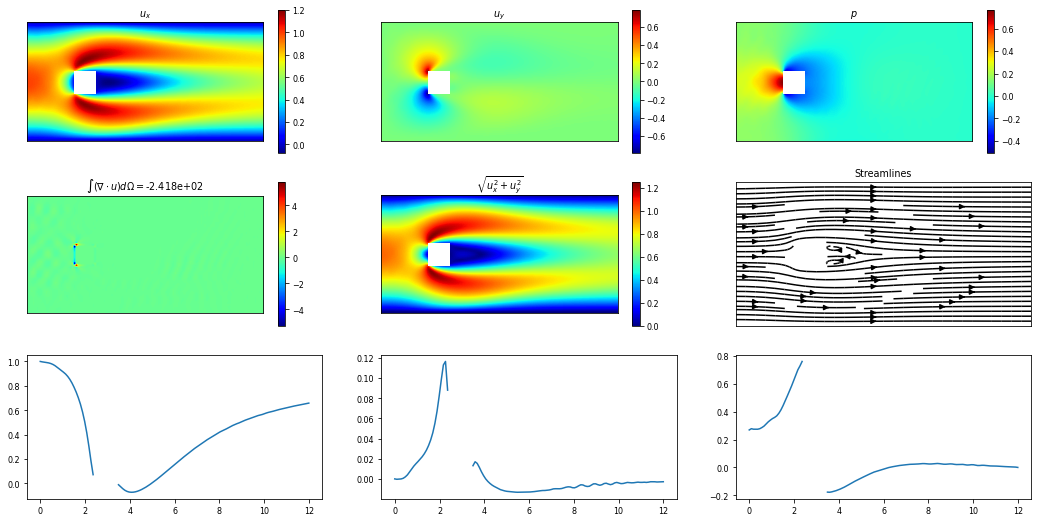

In [13]:
obj_left_idx = dataset.obj_left_idx
obj_rght_idx = dataset.obj_rght_idx
obj_bttm_idx = dataset.obj_bttm_idx
obj_top__idx = dataset.obj_top__idx
u[obj_bttm_idx:obj_top__idx, obj_left_idx:obj_rght_idx] = float('inf')
v[obj_bttm_idx:obj_top__idx, obj_left_idx:obj_rght_idx] = float('inf')
p[obj_bttm_idx:obj_top__idx, obj_left_idx:obj_rght_idx] = float('inf')
# plot
filepath = os.path.join(case_dir,'query_ns_fps.png')
plot_contours(equation, u, v, p, u_x, v_y, filepath)

In [12]:
net_u.cpu()

ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 1x1x64x128])

In [10]:
net_u

ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 1x1x64x128])

In [17]:
simdata = np.loadtxt('ns-ldc-numerical-results/re-30-ns-L12-H6-midlineX.csv', skiprows=1,delimiter=',')

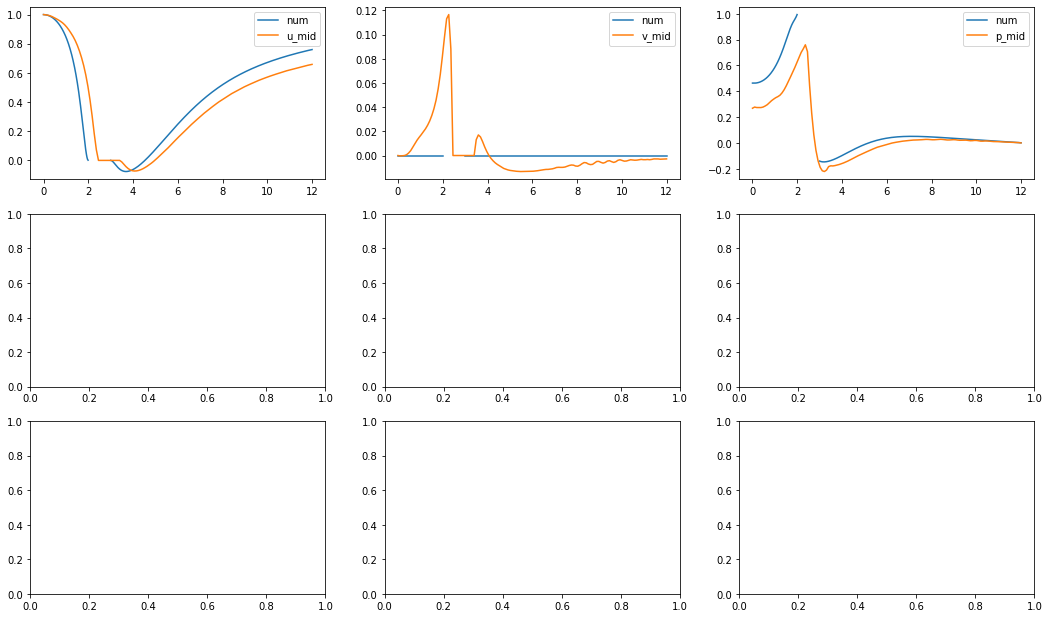

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(6*3,3.6*3), subplot_kw={'aspect': 'auto'}, squeeze=True)
axs[0,0].plot(simdata[:,0], simdata[:,2],label='num')
axs[0,1].plot(simdata[:,0], simdata[:,3],label='num')
axs[0,2].plot(simdata[:,0], simdata[:,1],label='num')
mid_idxX = int(Nx/2)
mid_idxY = int(Ny/2)
axs[0,0].plot(equation.dataset.x[mid_idxY,:], u[mid_idxY,:],label='u_mid'); axs[0,0].legend()
axs[0,1].plot(equation.dataset.x[mid_idxY,:], v[mid_idxY,:],label='v_mid'); axs[0,1].legend()
axs[0,2].plot(equation.dataset.x[mid_idxY,:], p[mid_idxY,:],label='p_mid'); axs[0,2].legend()

In [19]:
simdataY = np.loadtxt('ns-ldc-numerical-results/re-30-ns-L12-H6-midlineY.csv', skiprows=1,delimiter=',')

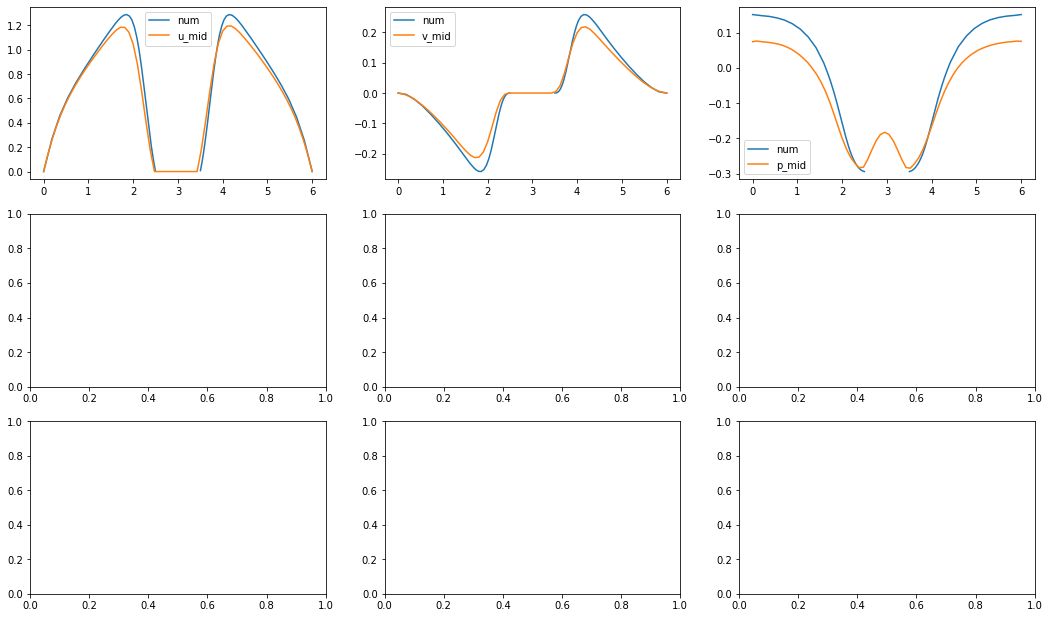

In [20]:
fig, axs = plt.subplots(3, 3, figsize=(6*3,3.6*3), subplot_kw={'aspect': 'auto'}, squeeze=True)
axs[0,0].plot(simdataY[:,0], simdataY[:,2],label='num')
axs[0,1].plot(simdataY[:,0], simdataY[:,3],label='num')
axs[0,2].plot(simdataY[:,0], simdataY[:,1],label='num')
mid_idxX = int(Nx/2)
mid_idxY = int(Ny/2)
axs[0,0].plot(equation.dataset.y[:,mid_idxY], u[:,mid_idxY],label='u_mid'); axs[0,0].legend()
axs[0,1].plot(equation.dataset.y[:,mid_idxY], v[:,mid_idxY],label='v_mid'); axs[0,1].legend()
axs[0,2].plot(equation.dataset.y[:,mid_idxY], p[:,mid_idxY],label='p_mid'); axs[0,2].legend()